# Entraînement du modèle de prédiction CO2
Ce notebook prépare les données et entraîne un modèle RandomForest pour prédire les émissions de CO2.

In [5]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import sys
import os

# Ajout du dossier src au path pour importer les fonctions de prétraitement
sys.path.append('../src')
from preprocessing import load_co2_data, prepare_splits

## Chargement et Prétraitement

In [6]:
DATA_PATH = '../data/CO2 Emissions_Canada.csv'
df, _ = load_co2_data(DATA_PATH)
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,0,1057,0,2.0,4,14,4,9.9,6.7,8.5,33,196
1,0,1057,0,2.4,4,25,4,11.2,7.7,9.6,29,221
2,0,1058,0,1.5,4,22,4,6.0,5.8,5.9,48,136
3,0,1233,11,3.5,6,15,4,12.7,9.1,11.1,25,255
4,0,1499,11,3.5,6,15,4,12.1,8.7,10.6,27,244


## Préparation des données

In [7]:
target = 'CO2 Emissions(g/km)'
X_train, X_test, y_train, y_test, scaler, _ = prepare_splits(df, target_col=target)

print(f"Taille X_train: {X_train.shape}")
print(f"Taille X_test: {X_test.shape}")

Taille X_train: (5908, 11)
Taille X_test: (1477, 11)


## Entraînement du modèle

In [8]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

## Évaluation

In [9]:
y_pred = model.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} g/km")

R2 Score: 0.9977
MAE: 1.79 g/km


## Importance des variables

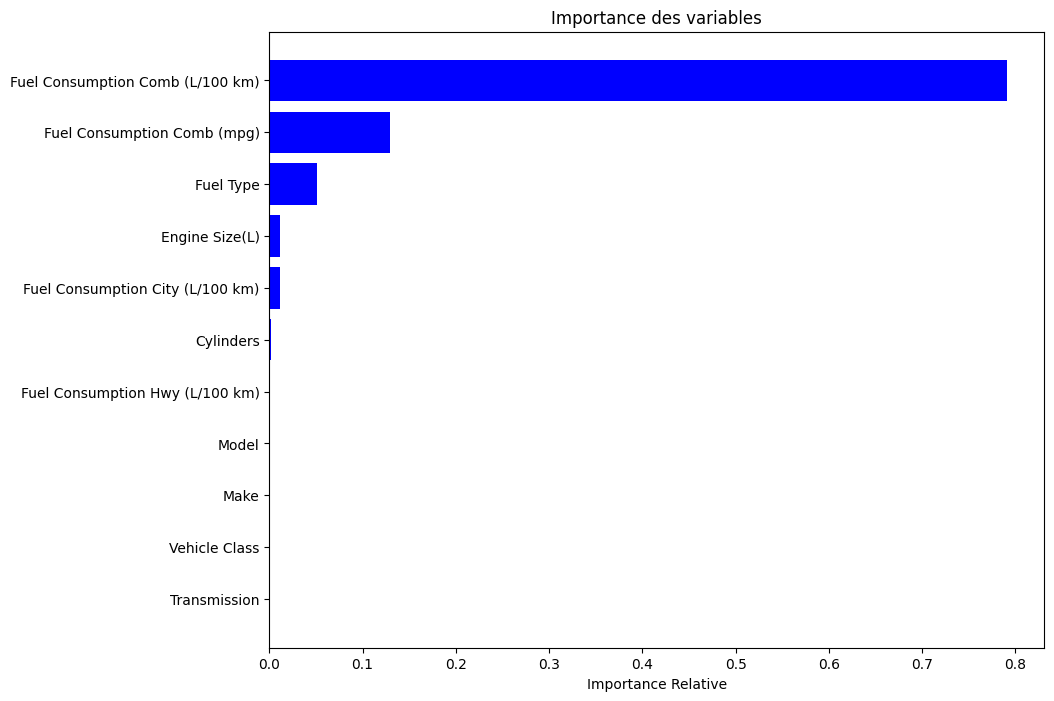

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

features = df.drop(columns=[target], errors='ignore').columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Importance des variables')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance Relative')
plt.show()

## Exportation du modèle (ONNX)

In [11]:
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType
import onnx

initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onx = skl2onnx.convert_sklearn(model, initial_types=initial_type)

model_path = "../models/co2_model_from_notebook.onnx"
with open(model_path, "wb") as f:
    f.write(onx.SerializeToString())

print(f"✅ Modèle exporté vers {model_path}")

✅ Modèle exporté vers ../models/co2_model_from_notebook.onnx
